# 実験3-2 次元圧縮

一般に高次元のデータは，可視化などが困難であるため，直感的にデータを理解することが難しいです．演習１で低次元（２次元）のデータを取り扱ったのも，直感的な理解を深めるためです．
その一方で，一般的なデータは高次元の場合がほとんどです．
そこで，高次元のデータを可視化したり，低次元に射影して使われる教師なし学習方法が次元圧縮と言われているものになります．
データを（２次元空間などの）低次元へ射影することで，可視化したり，データが表現される有効な空間のなかでの取り扱いをすることで，機械学習のアルゴリズムの効率を上げたりすることが次元圧縮の趣旨になります．

次元圧縮の方法としては，いくつかのやり方があります

- 主成分分析 （Principal Component Analysis: PCA）
- t-SNE, UMAP 局所構造を保ちながら次元を圧縮

などが比較的有名な方法です．ここでは簡単な主成分分析を取り上げます．
主成分分析は，データが最も拡がっている線形部分空間を取り出して，そこにデータ点を射影します．

## ３次元に埋め込まれたデータの主成分分析

まずは手始めに，視覚的な理解を目的として３次元空間に埋め込まれたデータを主成分分析を用いて２次元に射影して，次元圧縮を考えます．

下記のデータでは，３次現状の渦巻き構造を考えます

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# データ生成 (3次元空間に埋め込まれたスパイラル)
def generate_3d_spiral_data(n_samples=100, magnitude=1, noise=0.05):
    """
    3次元空間に埋め込まれたスパイラルデータを生成する
    n_samples : int
        データ数
    magnitude : float
        スパイラルの開き具合
    noise : float
        gaussian noiseの標準偏差
    生成データ，媒介変数θ，ノイズなし生成データを返す．
    なお各データは(n_samples, 3)の形状を持つ
    """
    theta = np.linspace(0, 4 * np.pi, n_samples)  # 角度
    z = np.linspace(0, 1, n_samples)  # 高さ
    r = magnitude * z  # 半径
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    true_data_3d = np.vstack((x, y, z)).T

    # データにノイズを載せる
    data_3d = true_data_3d + np.random.randn(n_samples*3).reshape(n_samples, 3) * noise
    return theta, true_data_3d, data_3d


N = 500 # データ数
a = 0.9 # 螺旋の開き具合
sd = 0.02 # データにノイズを載せる(0.05 くらいにすると面白い)

theta, true_data_3d, data_3d = generate_3d_spiral_data(n_samples=N, magnitude=a, noise=sd)


これで `data_3d` に，３次元で５００個のサンプルデータが生成されます．
データは $R^3 \in \{(x, y, z)\mid [-1, 1] \times [-1, 1] \times [0, 1]\}$ な空間に埋め込まれているはずなので
可視化してみます．
パラメータ `a` をコントロールすることで，渦巻きの $x-y$ 方向のサイズを変えることができることを確認してみてください．

(0.0, 1.0)

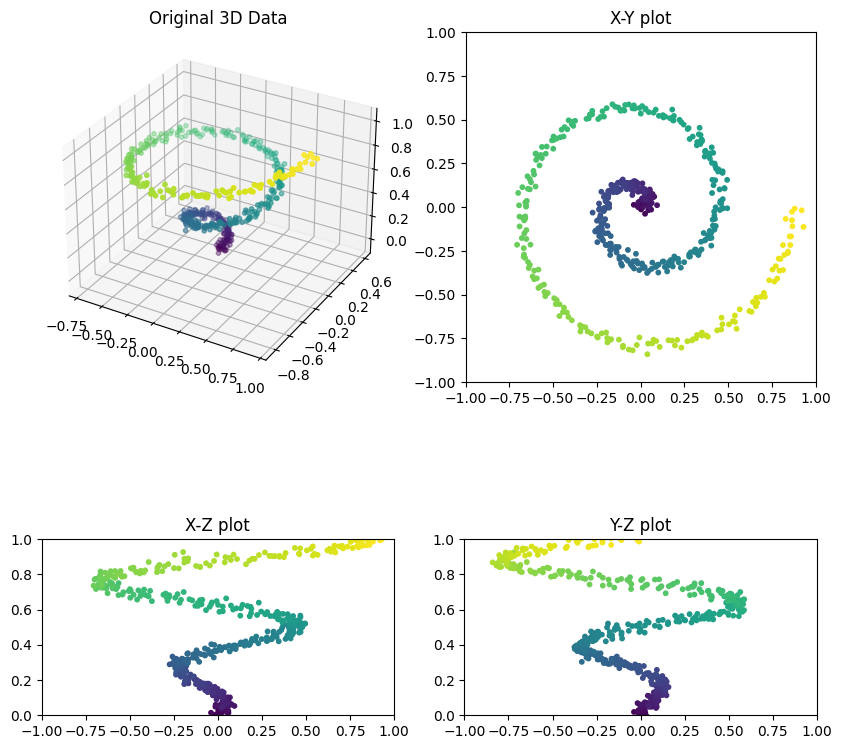

In [2]:
# 可視化
fig = plt.figure(figsize=(10, 10))

# 3D plot
ax0 = fig.add_subplot(2, 2, 1, projection='3d')
ax0.scatter(data_3d[:, 0], data_3d[:, 1], data_3d[:, 2], c=theta, s=10, cmap='viridis')
ax0.set_title("Original 3D Data")

# X-Y plot
ax1 = fig.add_subplot(2, 2, 2)
ax1.scatter(data_3d[:, 0], data_3d[:, 1], c=theta, cmap='viridis', s=10)
ax1.set_title("X-Y plot")
ax1.set_aspect('equal')
ax1.set_xlim(-1, 1)
ax1.set_ylim(-1, 1)

# X-Z plot
ax2 = fig.add_subplot(2, 2, 3)
ax2.scatter(data_3d[:, 0], data_3d[:, 2], c=theta, cmap='viridis', s=10)
ax2.set_title("X-Z plot")
ax2.set_aspect('equal')
ax2.set_xlim(-1, 1)
ax2.set_ylim(0, 1)

# Y-Z plot
ax3 = fig.add_subplot(2, 2, 4)
ax3.scatter(data_3d[:, 1], data_3d[:, 2], c=theta, cmap='viridis', s=10)
ax3.set_title("Y-Z plot")
ax3.set_aspect('equal')
ax3.set_xlim(-1, 1)
ax3.set_ylim(0, 1)


#### PCA による主成分分析

主成分分析は，データ全体から，その拡がった方向を抽出します．
データ自体から広がり方という特性を取り出すことから，教師なし学習と捉えることができます．
実装自体は，さまざまなプラットフォームで実装されていますが，ここでは `scikit-learn` に実装されたもの(`sklearn.decomposition.PCA`: 以下 `PCA` クラスと呼びます)を使っていきます．

`PCA` クラスではインスタンスを作成する場合，どのくらいに次元を落とすかを指定します．
ここでは，可視化するために２次元を指定します．

`scikit-learn` を用いる場合，通常 `fit()` 関数を使うことで学習が行われます．
さらにデータを与えて，特性に合わせた変換を行うには， `fit_transform()` を用います．
主成分分析を用いた場合は，拡がった次元方向を特定し，データをその次元へ射影します．

In [3]:
from sklearn.decomposition import PCA

# PCAで次元圧縮 (2次元)
pca = PCA(n_components=2)
data_2d = pca.fit_transform(data_3d)


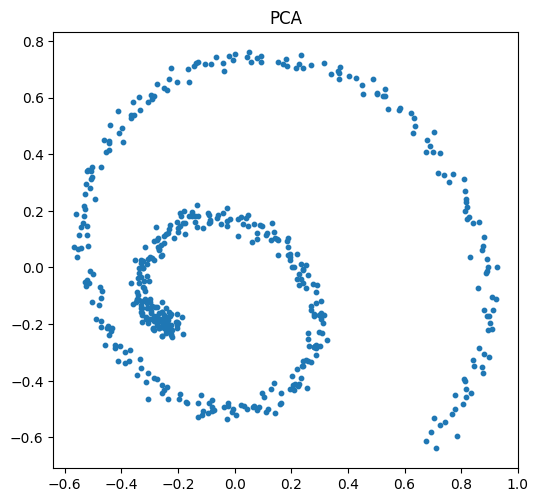

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.scatter(data_2d[:, 0], data_2d[:, 1], s=10)
ax.set_title("PCA")
ax.set_aspect('equal')

## 次元を大きくして一般化してみる

先ほどは３次元の可視化できるデータをランダムなデータを策定して，上述の渦巻き構造を 100 次元に埋め込まれた３次元の話として考えてみます．
データの生成としては，先ほどの螺旋状の３次元データを作成し，これを１０次元空間に埋め込んで，あとは適当な直交座標変換することで，人工データを作成します．

In [15]:
import numpy as np
import matplotlib.pyplot as plt

def embed_high_dimension(embed_data, dim=100, noise=0.05):
    """
    dim 次元空間に埋め込む
    """
    N = embed_data.shape[0] # データ数
    true_M = embed_data.shape[1] # 意味のある次元数
    M_rest = dim - true_M # 意味のない次元数
    
    # 高次元のデータを生成
    data_high_dim = np.zeros((N, dim))
    random_data = np.random.randn(N*M_rest).reshape(N, M_rest) * noise
    data_high_dim[:, :3] = embed_data
    data_high_dim[:, 3:] = random_data
    return data_high_dim

def apply_random_rotation(data, noise=0.05):
    """
    データにランダムな回転を適用する
    """
    N, M = data.shape
    random_matrix = np.random.randn(M*M).reshape(M, M) * noise
    q, _ = np.linalg.qr(random_matrix) # QR 分解で直交行列に変換
    permuted_data = data @ q

    return permuted_data, q

# データ生成 (100次元空間に埋め込まれたスパイラル)
M = 100 # 次元数
N = 500 # データ数
a = 0.9 # 螺旋の開き具合

# 螺旋の方程式
theta, true_data, data_3d = generate_3d_spiral_data(n_samples=N, magnitude=a, noise=sd)
# とりあえず１００次元空間の最初の列に埋め込む
data_highdim = embed_high_dimension(data_3d, dim=M, noise=sd)
# データをランダム直交で変換して混ぜる
synth_data, q = apply_random_rotation(data_highdim)


これでもう，データがどう埋め込まれているか，わからなくなりました．
100次元全ては，次元が高すぎてすべて見れないですが，最初の10次元の特徴における散布図ぐらいまでは，ペアプロットで眺めることができます．
ペアプロットは `matplotlib` でつくることもできるのですが，面倒なので `seaborn` モジュールの機能を使います．このためにデータを一度 `pandas` のデータフレームに変換し，
それを `seaborn.pairplot` に突っ込みます．


なお，通常のデータサイエンス研究や機械学習研究では，このような構造が見えないような（隠されている）ものを与えられるのが一般的です．

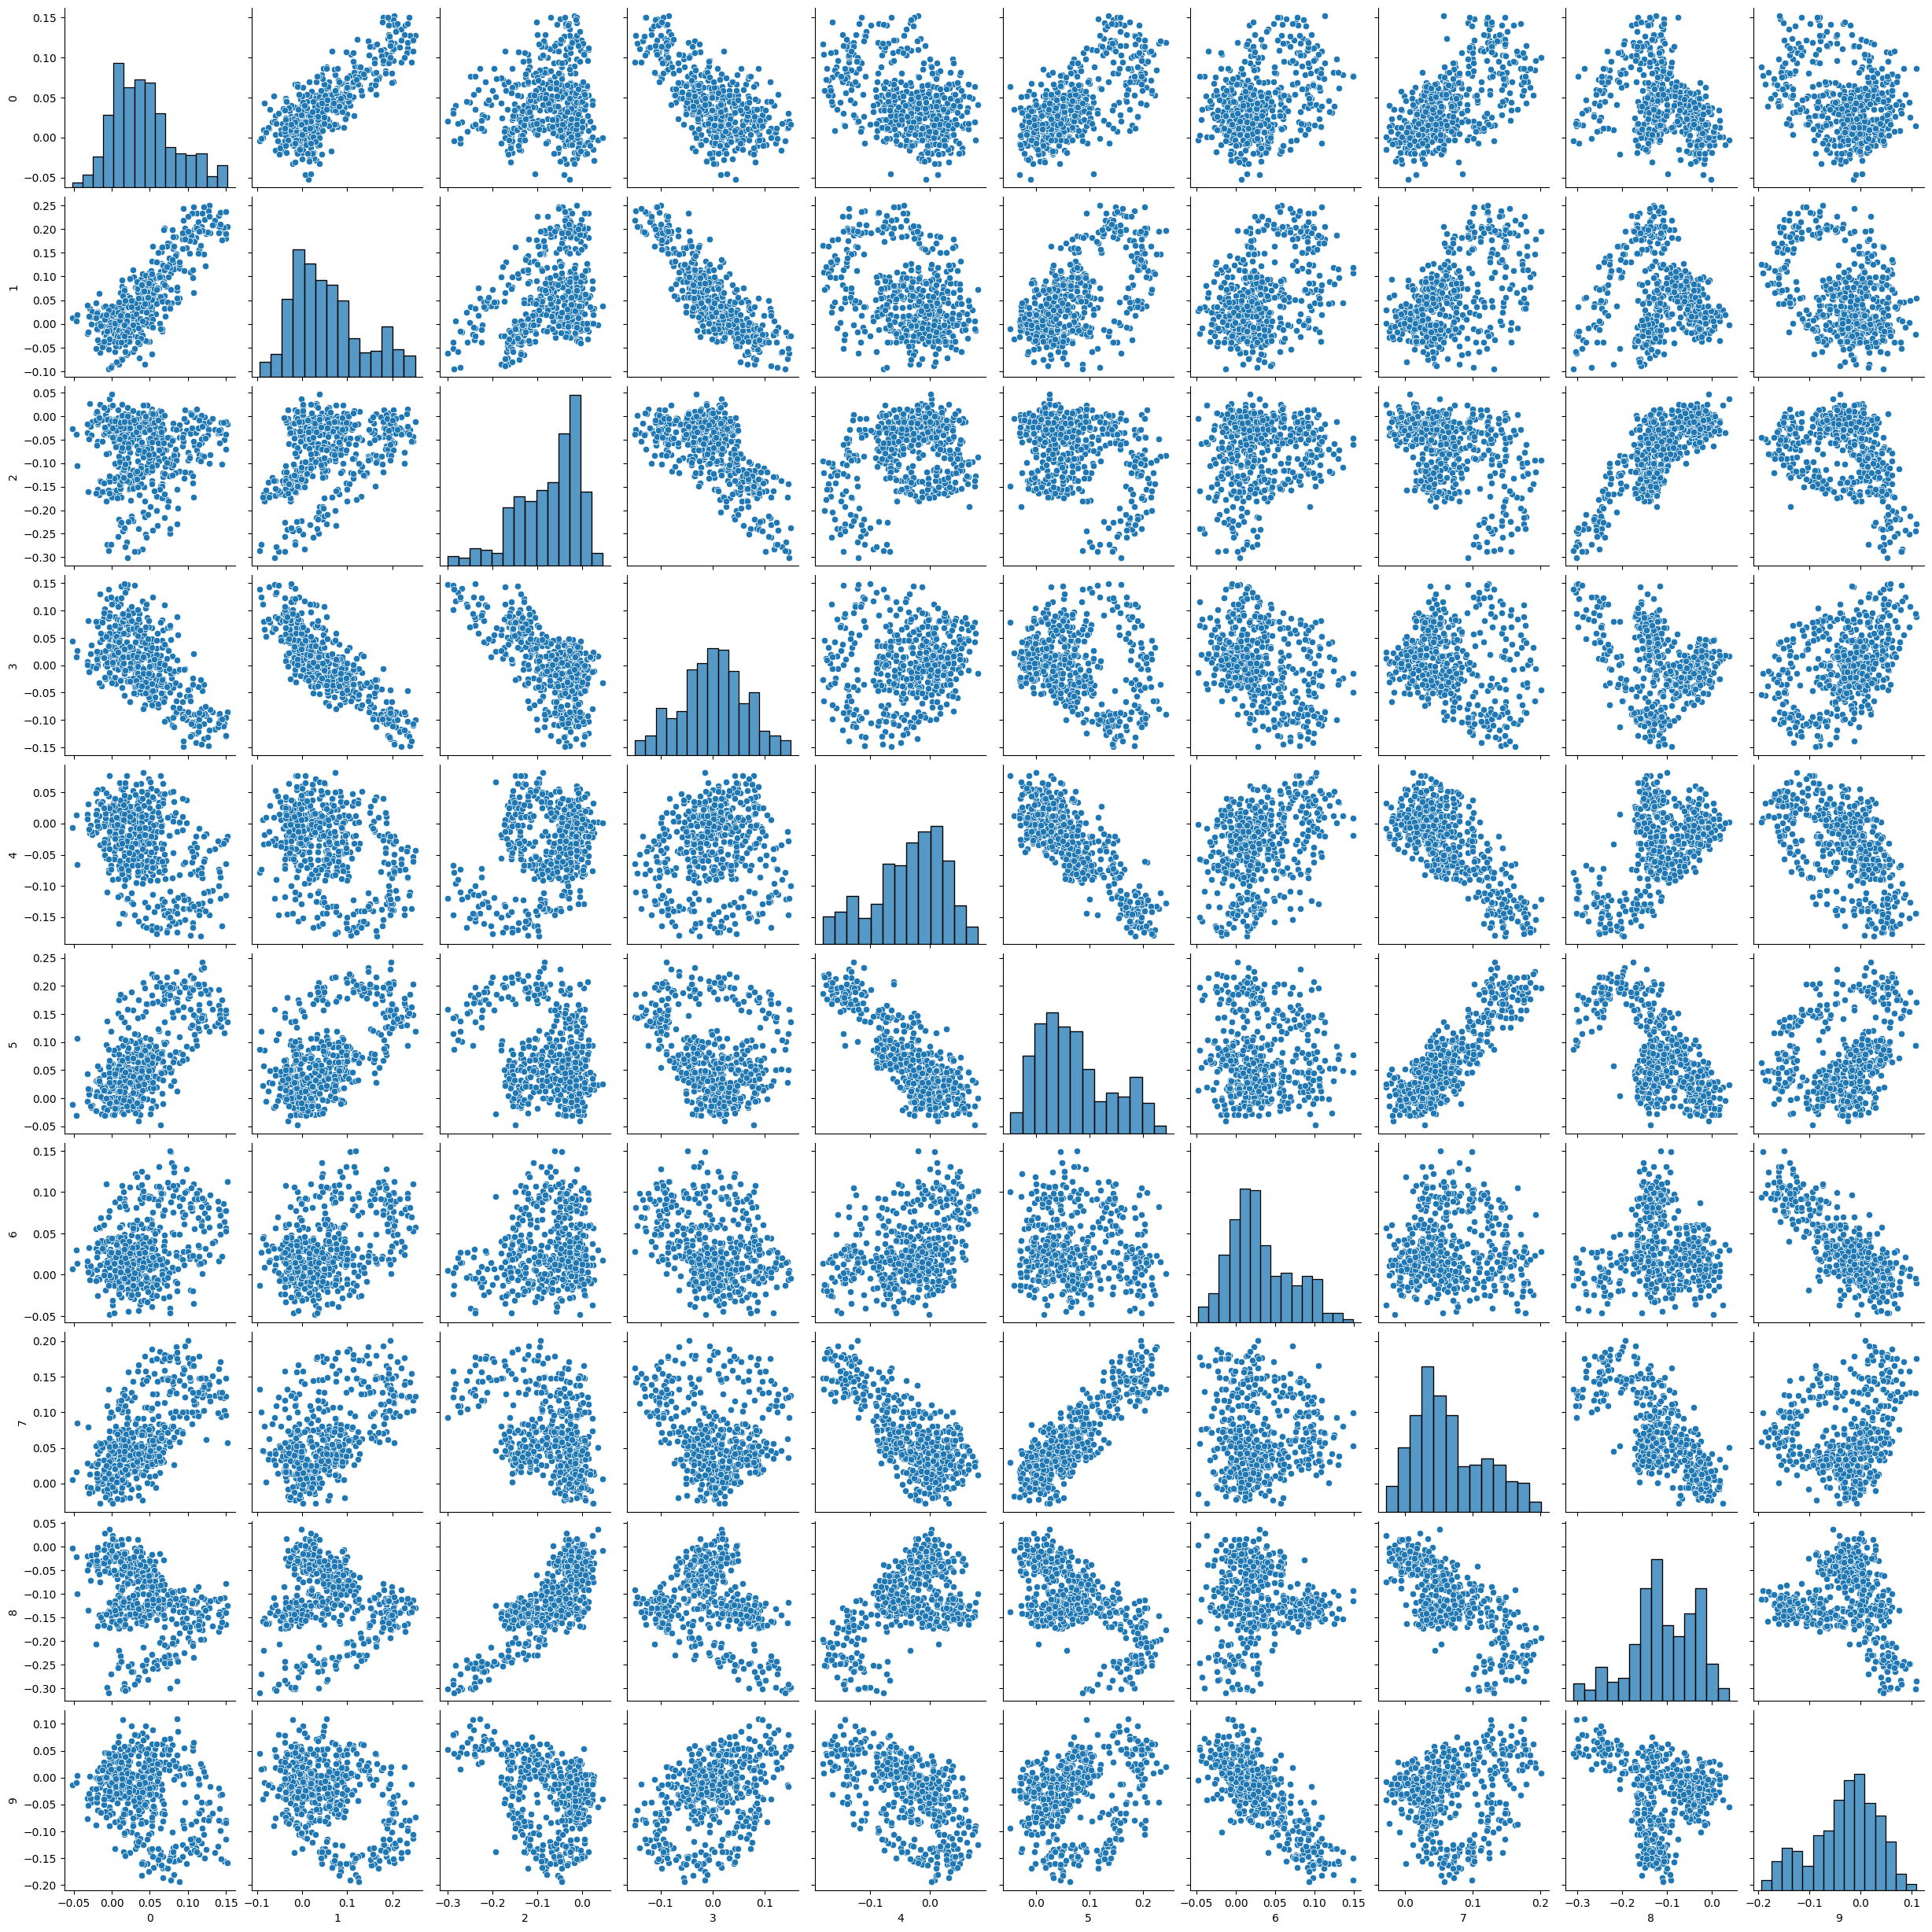

In [10]:
import seaborn as sns
import pandas as pd

# 10次元分のデータフレームつくってペアプロットしてみる
df = pd.DataFrame(synth_data[:, :10])
sns.pairplot(df)

# たぶん20次元くらいまでは pairplot で概観できる．

なにか構造ぽいものが，含まれているのがわかるかと思いますが，あまり明確ではないかと思います．
（sd の値を 0.05 程度にするとどの散布図も，みんな同じような正規分布に見えるようになってきます）

ただし，この場合，混ぜた直交行列 `q` がわかっているので，転置行列（逆行列でもある） `q.T` をかければ，もとの埋め込んだデータを復号できます．
下記のコードでみてみると，ちゃんと最初の3次元分にらせん構造が埋め込まれているのが下記で確認できます．

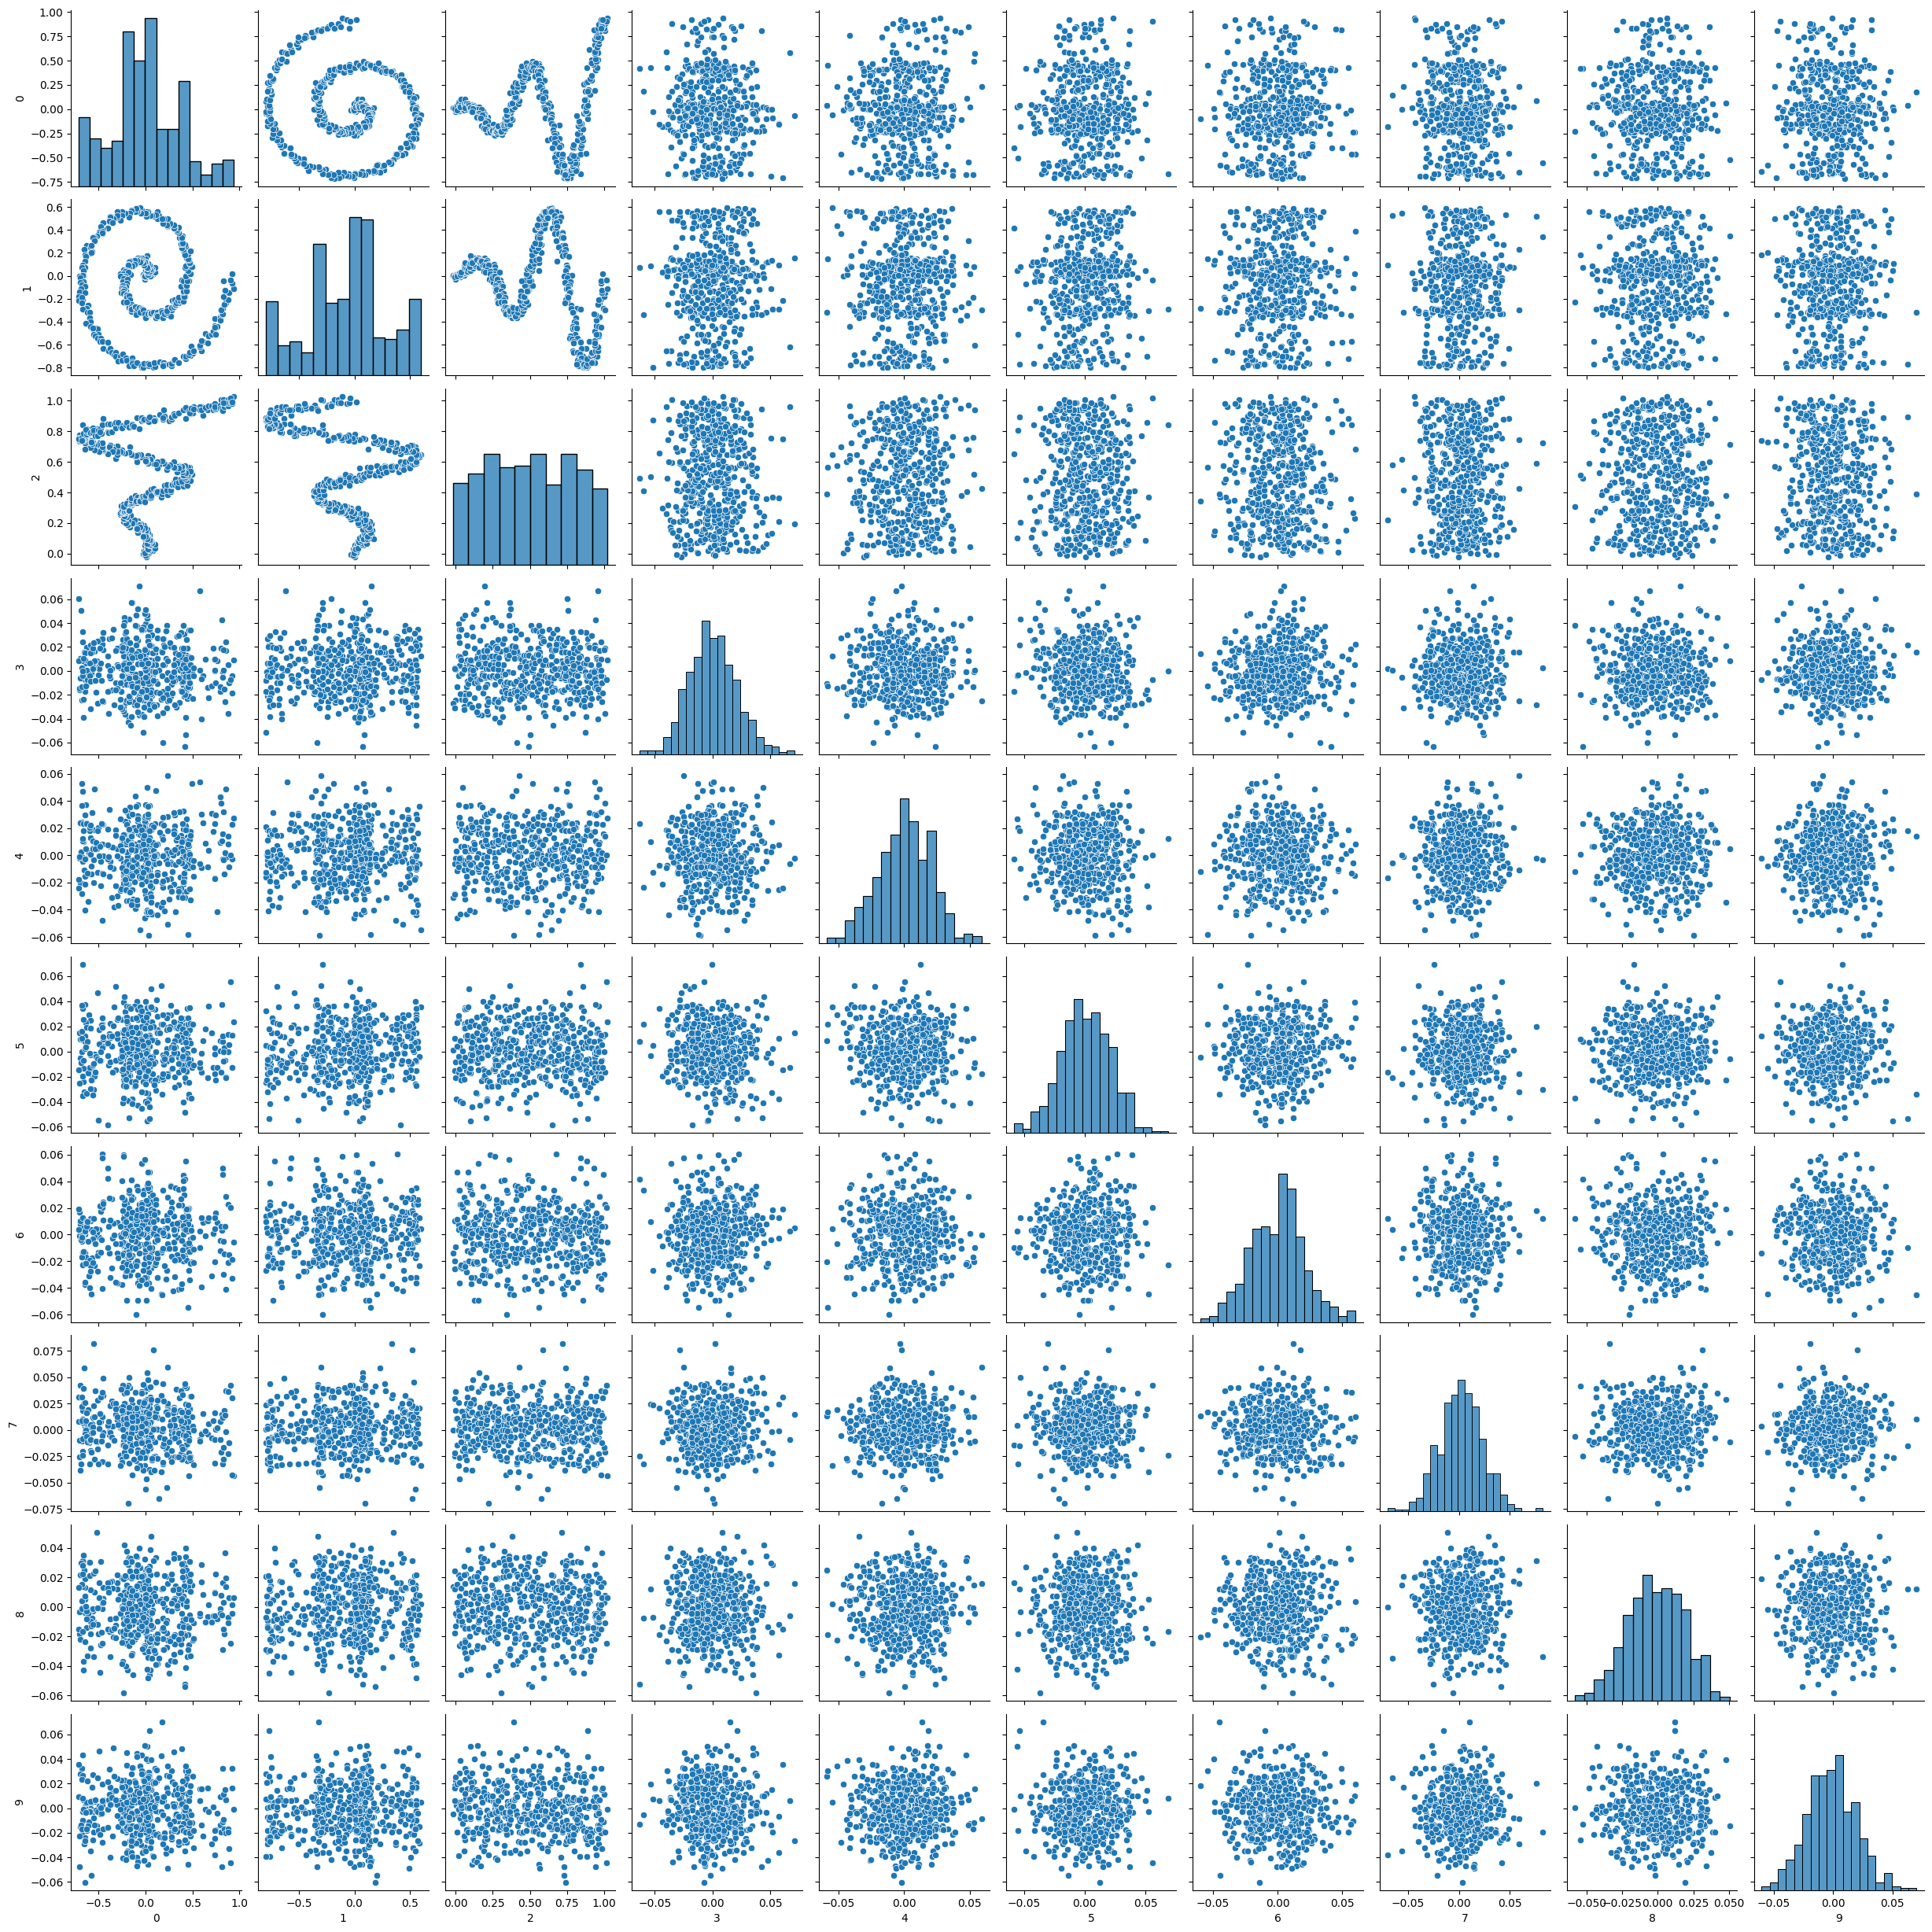

In [11]:
# もとのデータは q の逆行列（この場合は q.T）をかける
reconstruct_data = synth_data @ q.T

df2 = pd.DataFrame(reconstruct_data[:, :10])
sns.pairplot(df2)

さて，それでは，この `synthesized_data` から，PCA を用いてデータの構造を取り出すことができるかを見ていきます．
とりあえず次元数 (この場合 100) 次元で PCA をかけて，上位2つの軸を用いて散布図をとってみます．
これらの軸は *主成分* の軸と呼ばれ，データが定義されている空間で，拡がっている方向順に，第1主成分(The 1st Principal Component: PC1)，第2主成分(The 2nd Princial Compoent: PC2) と呼ばれます．

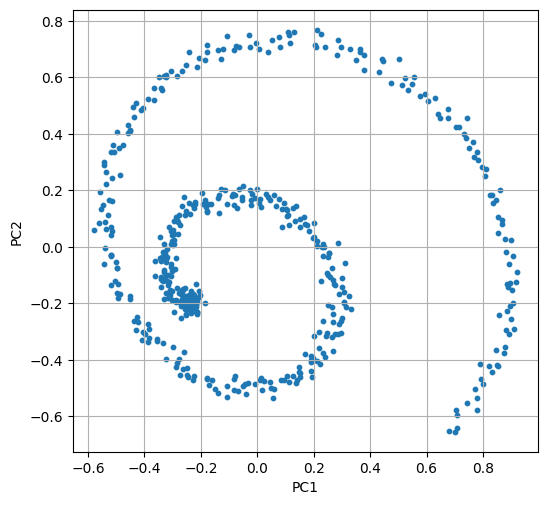

In [17]:
pca = PCA(n_components=100)
pca_decomposed = pca.fit_transform(synth_data)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.scatter(pca_decomposed[:, 0], pca_decomposed[:, 1], s=10)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.grid()
ax.set_aspect('equal')

もしくは，先ほどと同じ様に，PCAの各次元のペアプロットで概観をみることができます．

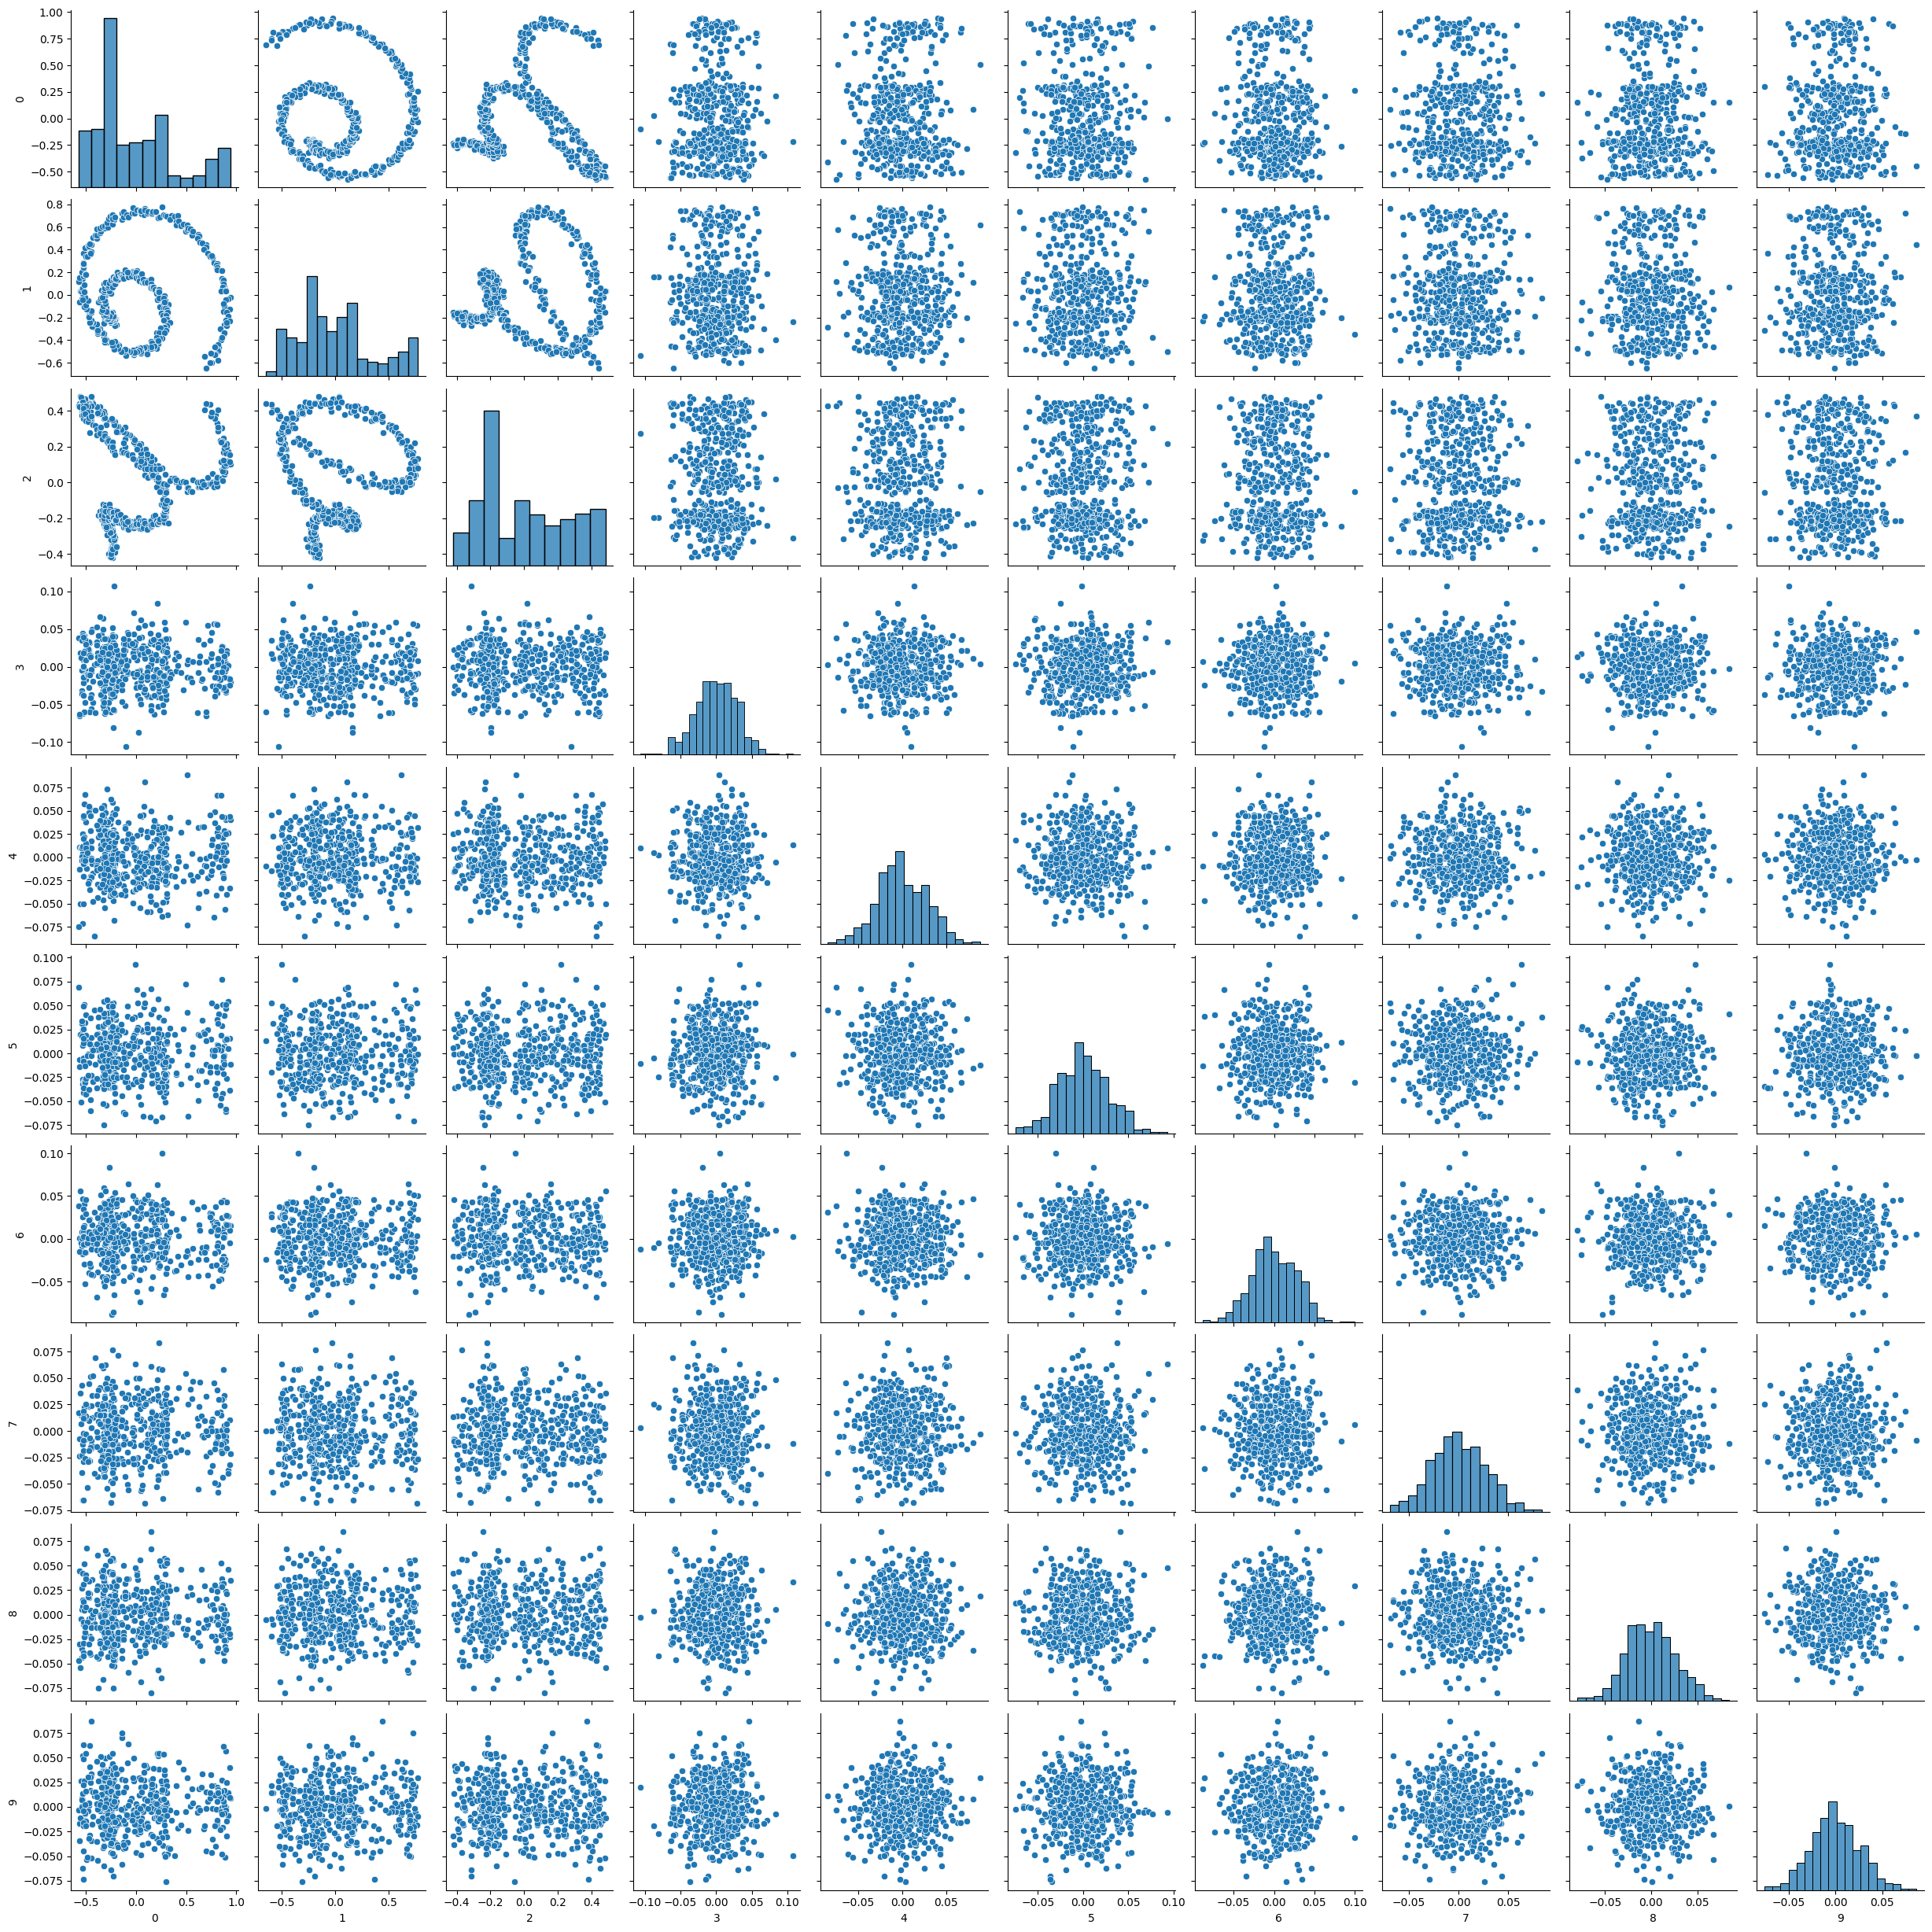

In [13]:
# もしくは pairplot で概観する
df3 = pd.DataFrame(pca_decomposed[:, :10])
sns.pairplot(df3)

データの中で，渦の構造が一番幅広く変化している場合は，うまく取り出せます．

それではデータが有効な次元はどのくらいかを見てみます．これは，データ全体のなかで，PCAの各次元がどの程度拡がっているかの割合をみることで指標を得ることができます．
これは *累積寄与率* と呼ばれる量になります．累積寄与率の計算は PCA の計算で出てくる固有値の割合を調べればよいのですが，ここらへんは多変量解析などの教科書に任せます．
`sklearn.decomposition` 内の `PCA` クラスの中では `explained_variance_ratio_` と呼ばれる値に，pca を行った各次元の寄与（固有値）が計算されていますので，
これの累積割合を出してあげます．
各次元の寄与を $v_m$ ($m = 1 \cdots M$) とすると $c_m = \frac{\sum_{j=1}^{m} v_j}{\sum_{k=1}^{M} v_k}$ という，$m$ 番目までの累積寄与は `numpy` の `cumsum` で計算できるのでやってみます．


Text(0.5, 1.0, 'PCA explained variance ratio')

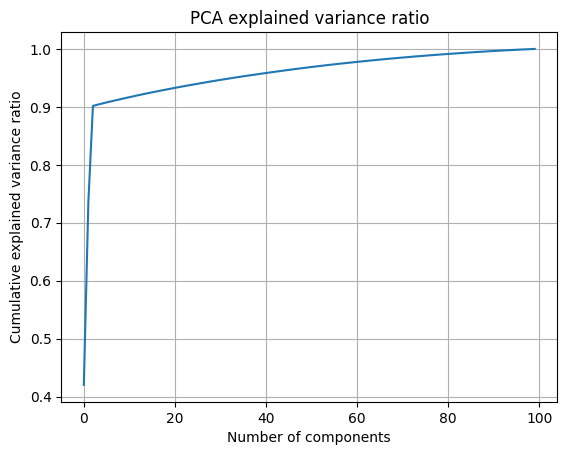

In [18]:
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)

fig, ax = plt.subplots(1, 1)
ax.plot(cumulative_explained_variance_ratio)
ax.grid()
ax.set_xlabel("Number of components")
ax.set_ylabel("Cumulative explained variance ratio")
ax.set_title("PCA explained variance ratio")

# ax.set_xlim(0, 10) # 10次元までの累積寄与率を見る



これをみると，最初の3つの要素だけで全体の9割を占めており，あとは徐々に上がっていくのが見えますので，最初の3つが重要そうというのが感覚的にわかります．
データへのノイズをあげると，この部分が上がったり下がったりします（sd = 0.05 にすると６割り程度）
累積寄与率が9割（9割のデータの広がり方を説明できる）までの次元をとるといった方法などは，割と標準的に次元を削減するのに使われます．

## t-SNE による次元圧縮

*t-SNE* や *UMAP* と呼ばれる手法は，主にデータを可視化するための次元圧縮方法です．
先ほどの主成分分析とは異なり，局所的なデータの近さの分布に基づいてマッピングするため，全体の構造を眺めることはできませんが，局所的なデータの構造を2次元に埋め込んで概観することができます．
先ほどの合成データを眺めてみます．

なお，t-SNE の場合，可視化が目的なので，圧縮する次元 `n_components` の値を4以上にすると警告が出てきます．

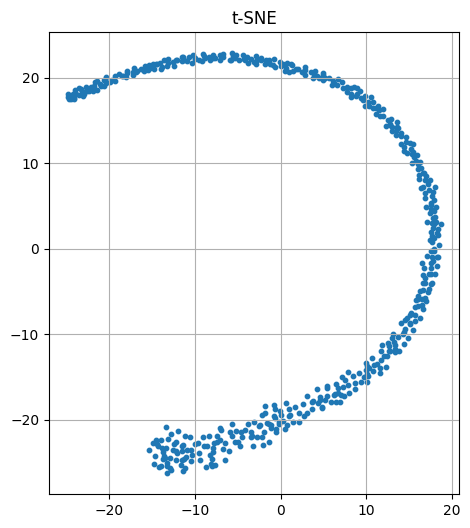

In [19]:
# 100次元のデータを t-SNE で2次元に圧縮
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)

tsne_decomposed = tsne.fit_transform(synth_data)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.scatter(tsne_decomposed[:, 0], tsne_decomposed[:, 1], s=10)
ax.set_title("t-SNE analysis")
ax.set_aspect('equal')
ax.grid()

どうやら，なにか構造があって，1次元ぽくも見えます．
上からデータの出現順（`theta` に相当）してみるともっとはっきりと構造が見えます．

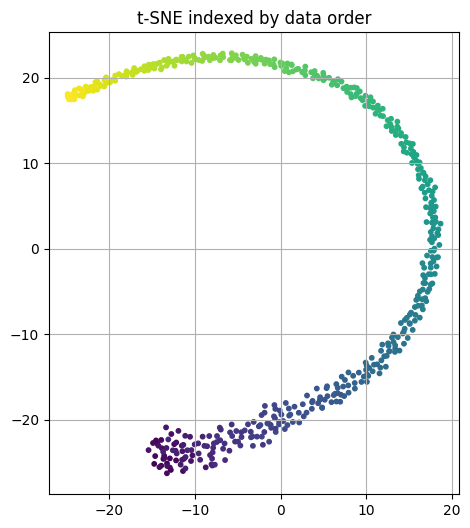

In [20]:
index = np.linspace(0, 1, N) # データの出現順に色をつける（theta に相当するが，データからとりだす）

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.scatter(tsne_decomposed[:, 0], tsne_decomposed[:, 1], c=index, cmap='viridis', s=10)
ax.set_title("t-SNE indexed by data order")
ax.set_aspect('equal')
ax.grid()


色の変化度合いからすると，構造的には1次元のものが曲がって100次元データの中にうめ込まれていて，
それを t-SNE で2次元にマッピングすると，その構造がほどかれて，可視化されていそうというのが見て取れます．さらに黄色のほうがデータの散らばりが少なく，濃い青のほうが散らばりが多いことからデータの最初と終わりとではデータの散らばり方が違うことも見えてきます．

さて，ここまでは，標準の t-SNE の使い方を見てきたわけですが，t-SNE 自体は *教師なし学習* の一種で，その振る舞いを変える（ハイパー）パラメータが存在します．
結果を大きく左右するハイパーパラメータは perplexity と呼ばれる値で，大雑把に言えば k-means 法のクラスタ数に該当するパラメータになります．
このアルゴリズムを提唱した Maaten と Hinton は，5~50 程度にしなさいと言っています．

以下に perplexity を 1~100 に変化させたものを図示します．

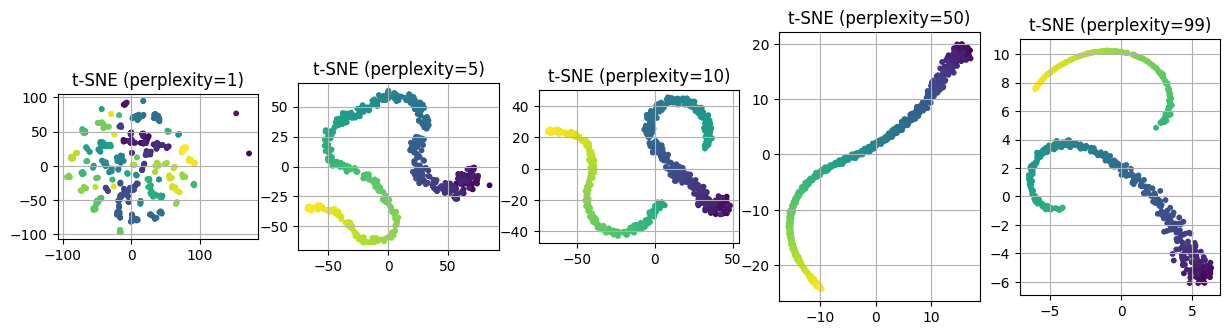

In [21]:
# 100次元のデータを t-SNE で2次元に圧縮
from sklearn.manifold import TSNE

perplexities = [1, 5, 10, 50, 99]
index = np.linspace(0, 1, synth_data.shape[0])

fig, ax = plt.subplots(1, len(perplexities), figsize=(15, 6))
ax = ax.ravel()

for i, p in enumerate(perplexities):
    tsne = TSNE(n_components=2, perplexity=p)
    tsne_decomposed = tsne.fit_transform(synth_data)

    ax[i].scatter(tsne_decomposed[:, 0], tsne_decomposed[:, 1], c=index, cmap='viridis', s=10)
    ax[i].set_title(f"t-SNE (perplexity={p})")
    ax[i].set_aspect('equal')
    ax[i].grid()
    


perplexity の違いによって，同じデータを用いてもぜんぜん違う可視化結果が得られるのがわかると思います．
この値が小さいとよくわからない配置になります．なので適切に設定する必要があります．（`sklearn` のデフォルトでは 30 に設定されている）
また，純粋なノイズを与えた場合にも，この値の設定次第で構造ぽくみえるようになるケースもあります．
PCAの場合は，データを見る角度を変えているだけなのですが，この場合は空間の伸縮させてもいるので，点の近さどうしはデータ点同士の密度の意味でしか当てになりません．

データを間引いた場合でも，また構造は変わってきます．


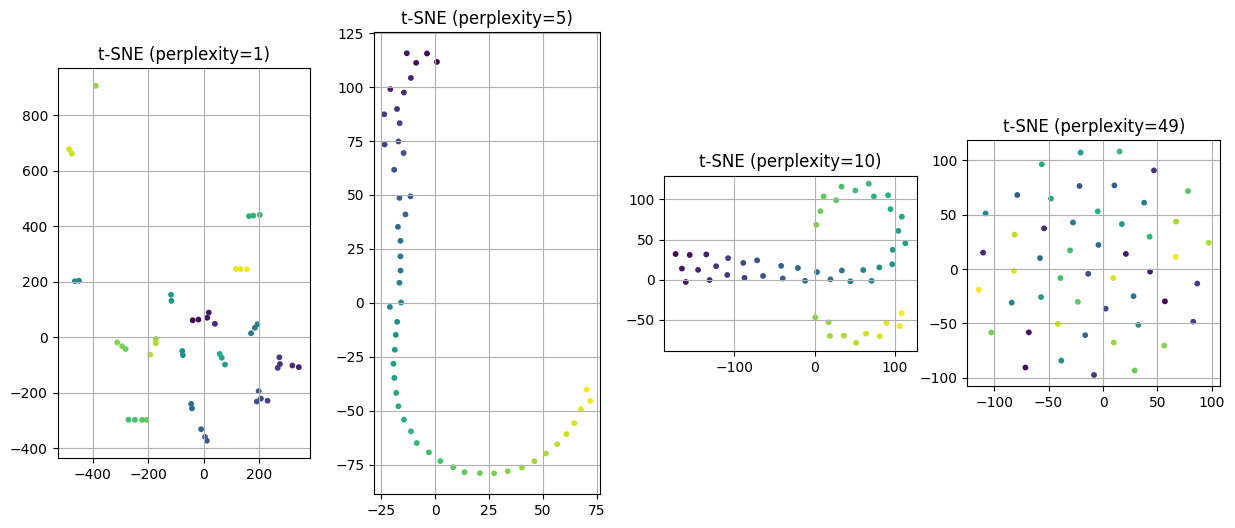

In [22]:
# 100次元のデータを t-SNE で2次元に圧縮
from sklearn.manifold import TSNE

reduced_data = synth_data[::10] # 1/10 だけ使う

perplexities = [1, 5, 10, 49]
index = np.linspace(0, 1, reduced_data.shape[0])

fig, ax = plt.subplots(1, len(perplexities), figsize=(15, 6))
ax = ax.ravel()

for i, p in enumerate(perplexities):
    tsne = TSNE(n_components=2, perplexity=p)
    tsne_decomposed = tsne.fit_transform(reduced_data)

    ax[i].scatter(tsne_decomposed[:, 0], tsne_decomposed[:, 1], c=index, cmap='viridis', s=10)
    ax[i].set_title(f"t-SNE (perplexity={p})")
    ax[i].set_aspect('equal')
    ax[i].grid()
    


今度は perpexity = 1 に謎のクラスタぽい集団が現れているのがわかります．（実際にはそんなものはない）

t-SNE や UMAP の場合は，このように見てくれを変えられる柔軟な（ミスリーディングさせることが可能な）手法であることを考慮したうえで使うことを心がけてください．

# 実験3-2

1. 上記らせん構造データの広がりパラメータ `a` の大きさを $0 \sim 1$ の間で制御することによって，どの程度の広がり方 ($a$) があれば，PCA で，らせん構造が取り出せそうかを考察しなさい．
2. MNIST (データ次元768) のデータ のうち，1000 個のデータを取り出した上で，PCA で次元圧縮をおこない，２次元で図示しなさい．
3. 上述のMNISTデータを t-SNE を用いて可視化し，PCA との違いを考察しなさい．